# 사이킷런으로 수행하는 타이나틱 생존자 예측
---

### 라이브러리 및 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# 브라우저 내부(inline)에 바로 그려지도록 해주는 코드
%matplotlib inline

In [2]:
titanic_df = pd.read_csv('./titanic_data/train.csv')
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
print('\n ### 학습 데이터 정보 ### \n')
print(titanic_df.info())


 ### 학습 데이터 정보 ### 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


##### 타이타닉 탑승자 데이터
* Passengerid : 탑승자 데이터 일련번호
* survived : 생존 여부, 0 = 사망, 1 = 생존
* pclass : 티켓의 선실 등급, 1 = 일등석, 2 = 이등석, 3 = 삼등석
* sex : 탑승자 성별
* name : 탑승자 이름
* Age : 탑승자 나이
* sibsp : 같이 탑승한 형제자매 또는 배우자 인원수
* parch : 같이 탑승한 부모님 또는 어린이 인원수
* ticket : 티켓 번호
* fare : 요금
* cabin : 선실 번호
* embarked : 중간 정착 항구 C = Cherbourg, Q = Queenstown, S = Southampton

##### Age, Cabin, Embarked는 Null값을 가지고있다.
* Age의 경우는 평균나이
* Cabin, Embarked는 'N' 값으로 변경
* isnull().sum().sum()을 통ㅇ해 전체 데이터 세트에 Null 값이 없는지 다시 확인

In [4]:
titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace = True)
titanic_df['Cabin'].fillna('N', inplace = True)
titanic_df['Embarked'].fillna('N', inplace = True)
print('데이터 세트 Null 값 개수 ', titanic_df.isnull().sum().sum())

데이터 세트 Null 값 개수  0


In [5]:
'''
문자열 피처 Sex, Cabin, Embarked
'''

print('Sex 값 분포 : \n', titanic_df['Sex'].value_counts())
print('\nCabin 값 분포 : \n', titanic_df['Cabin'].value_counts())
print('\nEmbarked 값 분포 : \n', titanic_df['Embarked'].value_counts())

Sex 값 분포 : 
 male      577
female    314
Name: Sex, dtype: int64

Cabin 값 분포 : 
 N              687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: Cabin, Length: 148, dtype: int64

Embarked 값 분포 : 
 S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64


In [6]:
# Cabin 속성의 경우 앞 문자만 추출
# titanic_df['Cabin'].str[:1] - 0번째 글자부터 1 까지, 0<=x<1
titanic_df['Cabin'] = titanic_df['Cabin'].str[0]
print(titanic_df['Cabin'].head())

0    N
1    C
2    N
3    C
4    N
Name: Cabin, dtype: object


In [7]:
titanic_df['Cabin'].value_counts()

N    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64

### 데이터 탐색 

In [8]:
# 성별에 따른 생존자 수 비교
titanic_df.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

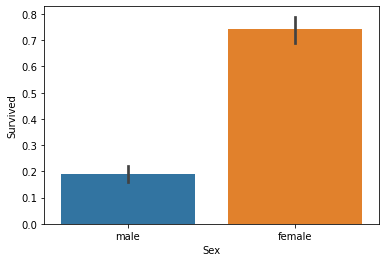

In [9]:
sns.barplot(x = 'Sex', y = 'Survived', data = titanic_df)

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

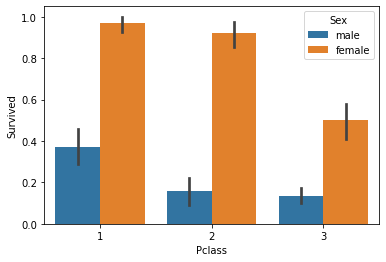

In [10]:
# 부자와 가난한 사람 간의 생존자 수 비교
sns.barplot(x = 'Pclass', y = 'Survived', hue = 'Sex', data = titanic_df)

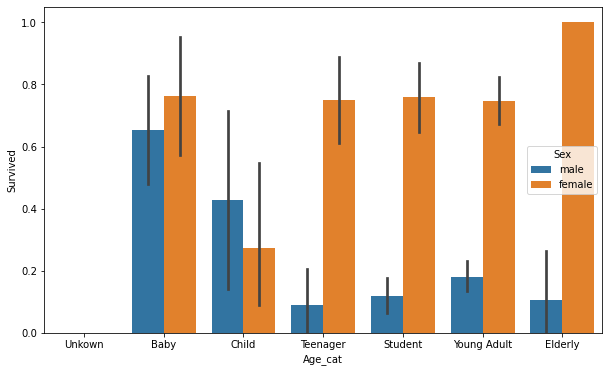

In [11]:
# 나이에 따른 생존자 수 비교

# Age에 따라 구분 값을 반환하는 함수 설정
def get_category(age):
    cat = ''
    if age <= -1: cat = 'Unknown'
    elif age <= 5: cat = 'Baby'
    elif age <= 12: cat = 'Child'
    elif age <= 18: cat = 'Teenager'
    elif age <= 25: cat = 'Student'
    elif age <= 35: cat = 'Young Adult'
    elif age <= 60: cat = 'Adult'
    else: cat = 'Elderly'
            
    return cat

# 막대그래프의 크기 설정
plt.figure(figsize = (10, 6))

# x축의 값을 순차적으로 표시하기 위한 설정
group_names = ['Unkown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Elderly']

titanic_df['Age_cat'] = titanic_df['Age'].apply(lambda x : get_category(x))
sns.barplot(x = 'Age_cat', y = 'Survived', hue = 'Sex', data = titanic_df, order = group_names)
titanic_df.drop('Age_cat', axis = 1, inplace = True)

### 인코딩

In [12]:
# 문자열 카테고리 피처 -> 숫자형 카테고리 피처로 변환

from sklearn.preprocessing import LabelEncoder

def encode_features(dataDF):
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(dataDF[feature])
        dataDF[feature] = le.transform(dataDF[feature])
        
    return dataDF

titanic_df = encode_features(titanic_df)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,7,3


In [13]:
'''
지금까지 피처를 가공한 내역을 정리하고 이를 쉽게 재사용할 수 있도록 함수 만들기
'''

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 피처 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩 수행.
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [14]:
# 원본 데이터를 재로딩 하고, feature데이터 셋과 Label 데이터 셋 추출. 
titanic_df = pd.read_csv('./titanic_data/train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df= titanic_df.drop('Survived',axis=1)

X_titanic_df = transform_features(X_titanic_df)

In [15]:
# train_test_split()
# 테스트 데이터 세트 크기는 전체의 20% 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

### ML 알고리즘인 결정 트리, 랜덤 포레스트, 로지스틱 회귀를 이용해 타이타닉 생존자 예측
분류 알고리즘
* 결정 트리 : DecisionTreeClassifier
* 랜덤 포레스트 : RandomForestClassifier
* 로지스틱 회귀 : LogisticRegression

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 결정트리, Random Forest, 로지스틱 회귀를 위한 사이킷런 Classifier 클래스 생성
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression(solver='liblinear')

# DecisionTreeClassifier 학습/예측/평가
dt_clf.fit(X_train , y_train)
dt_pred = dt_clf.predict(X_test)
print('DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))

# RandomForestClassifier 학습/예측/평가
rf_clf.fit(X_train , y_train)
rf_pred = rf_clf.predict(X_test)
print('RandomForestClassifier 정확도:{0:.4f}'.format(accuracy_score(y_test, rf_pred)))

# LogisticRegression 학습/예측/평가
lr_clf.fit(X_train , y_train)
lr_pred = lr_clf.predict(X_test)
print('LogisticRegression 정확도: {0:.4f}'.format(accuracy_score(y_test, lr_pred)))

DecisionTreeClassifier 정확도: 0.7877
RandomForestClassifier 정확도:0.8547
LogisticRegression 정확도: 0.8659


* 3개의 알고리즘 중 LogisticRegression이 높은 정확도를 나타내고 있다.
##### But, 최적화 작업을 수행하지 않았고, 데이터양도 충분하지 않기 때문에 어떤 알고리즘이 가장 성능이 좋다고평가할 수는 없다.


### 교차 검증으로 결정 트리(DecisionTreeClassifier) 모델 평가
* KFold
* cross_val_score()
* GridSearchCV

In [17]:
from sklearn.model_selection import KFold

def exec_kfold(clf, folds = 5):
    # 폴드 세트를 5개인 KFold객체를 생성
    # 폴드 수만큼 예측결과 저장을 위한 리스트 객체 생성
    kfold = KFold(n_splits=folds)
    scores = []
    
    # KFold 교차 검증 수행
    for iter_count, (train_index, test_index) in enumerate(kfold.split(X_titanic_df)): # enumerate : 인덱스와 요소의 값을 풀어서 되돌려주는 함수 
        # X_titanic_df 데이터에서 교차 검증별로 학습과 검증 데이터를 가리키는 index 생성
        X_train, X_test = X_titanic_df.values[train_index], X_titanic_df.values[test_index]
        y_train, y_test = y_titanic_df.values[train_index], y_titanic_df.values[test_index]
        
        # Classifier 학습, 예측, 정확도 계산 
        clf.fit(X_train, y_train) 
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        scores.append(accuracy)
        print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))     
    
    # 5개 fold에서의 평균 정확도 계산. 
    mean_score = np.mean(scores)
    print("평균 정확도: {0:.4f}".format(mean_score)) 
# exec_kfold 호출
print('### DecisionTreeClassifier ###')
exec_kfold(dt_clf , folds=5) 
print('\n### RandomForestClassifier ###')
exec_kfold(rf_clf , folds=5)
print('\n### LogisticRegression ###')
exec_kfold(lr_clf , folds=5) 

### DecisionTreeClassifier ###
교차 검증 0 정확도: 0.7542
교차 검증 1 정확도: 0.7809
교차 검증 2 정확도: 0.7865
교차 검증 3 정확도: 0.7697
교차 검증 4 정확도: 0.8202
평균 정확도: 0.7823

### RandomForestClassifier ###
교차 검증 0 정확도: 0.7933
교차 검증 1 정확도: 0.8090
교차 검증 2 정확도: 0.8371
교차 검증 3 정확도: 0.7753
교차 검증 4 정확도: 0.8596
평균 정확도: 0.8148

### LogisticRegression ###
교차 검증 0 정확도: 0.7933
교차 검증 1 정확도: 0.7921
교차 검증 2 정확도: 0.7753
교차 검증 3 정확도: 0.7472
교차 검증 4 정확도: 0.8427
평균 정확도: 0.7901


##### 결정 트리 모델 평균 정확도는 약 78.23%
##### 랜덤 포레스트모델 평균 정확도는 약 81.48%
##### 로지스틱 회귀 모델 평균 정확도는 약 79.01%

### cross_val_score() API 적용

In [18]:
# 결정 트리 모델
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_clf, X_titanic_df, y_titanic_df, cv = 5)

for iter_count, accuracy in enumerate(scores):
    print('교차 검증 {0} 정확도: {1:4f}'.format(iter_count, accuracy))
    
print('평균 정확도: {0:4f}', format(np.mean(scores)))

교차 검증 0 정확도: 0.743017
교차 검증 1 정확도: 0.775281
교차 검증 2 정확도: 0.792135
교차 검증 3 정확도: 0.786517
교차 검증 4 정확도: 0.842697
평균 정확도: {0:4f} 0.7879291946519366


##### 결정 트리 모델 평균 정확도 78.79%
##### cross_val_score 와 KFold 평균 정확도가 다른 이유: cross_val_score는 StratifiedKFold를 이용해  폴드 세트를 분할하기 때문.

### GridSearchCV를 이용해 DecisionTreeClassifier의 최적 하이퍼 파라미터를 찾고 예측 성능을 측정

* CV는 5개의 폴드 세트를 지정
* 하이퍼 파라미터
   * max_depth
   * min_samples_split
   * min_samples_leaf

In [19]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[2,3,5,10],
             'min_samples_split':[2,3,5], 'min_samples_leaf':[1,5,8]}

grid_dclf = GridSearchCV(dt_clf , param_grid=parameters , scoring='accuracy' , cv=5)
grid_dclf.fit(X_train , y_train)

print('GridSearchCV 최적 하이퍼 파라미터 :',grid_dclf.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_

# GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행. 
dpredictions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test , dpredictions)
print('테스트 세트에서의 DecisionTreeClassifier 정확도 : {0:.4f}'.format(accuracy))

GridSearchCV 최적 하이퍼 파라미터 : {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.7992
테스트 세트에서의 DecisionTreeClassifier 정확도 : 0.8715


##### max_depth = 3, min_samples_leaf = 5, min_samples_split = 2로 DecisionTreeClassifier를 학습시킨 뒤 예측 정확도가 약 87.15%로 향상